In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns
import re
import json
import requests
import subprocess
import glob
import os
import geopandas as gpd
from geopandas import GeoDataFrame
from pygeocoder import Geocoder
import scikit_posthocs as sp
import scipy.stats as stats
import folium
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#import tensorflow
#import imblearn
#from imblearn.over_sampling import SMOTE

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#!pip install folium
#!pip install plotly
#!pip install scikit-posthocs
#!pip install tensorflow (to fix imblearn package issue using SMOTE)


In [3]:
tow = pd.read_csv('/Users/elizabethclick/Desktop/DATA205/tow_clean.csv')
tow.drop(tow[tow['hh_income'] < 0].index, inplace = True)
tow.head()

,tow_date,tow_reason,storage_company,street,city,geo_location,longitude,latitude,location,block,hh_income,pop_total,pop_black,state,tract
0,2020-12-11,REPO,Final Notice,21704 Stableview Dr,Gaithersburg,POINT (-77.175624 39.211873),-77.175624,39.211873,"(39.211873, -77.175624)",7001012,208929,1931,39,24,700101
1,2021-02-17,REPO,NaN,8212 Brink Rd,Gaithersburg,POINT (-77.167752 39.208712),-77.167752,39.208712,"(39.208712, -77.167752)",7001013,135208,800,10,24,700101
2,2021-02-10,REPO,Thomas,7321 Brink Rd,Gaithersburg,POINT (-77.148754 39.211605),-77.148754,39.211605,"(39.211605, -77.148754)",7001013,135208,800,10,24,700101
3,2020-02-15,REPO,Greenwood Recovery,21400 Laytonsville Rd,Gaithersburg,POINT (-77.141329 39.207148),-77.141329,39.207148,"(39.207148, -77.141329)",7001032,218173,1017,193,24,700103
4,2020-02-04,REPO,Greenwood Recovery,7571 Lindbergh Dr,Gaithersburg,POINT (-77.153158 39.166038),-77.153158,39.166038,"(39.166038, -77.153158)",7001033,172778,3112,345,24,700103


In [4]:
print(tow.shape)
print(tow[tow["storage_company"] == "Other"])

(19753, 15)
         tow_date tow_reason storage_company                  street  \
15     2020-08-02        PRV           Other  7501 Muncaster Mill Rd   
16     2020-08-12       FIRE           Other    17612 Phelps Hill Ln   
18     2020-12-20       REPO           Other  6314 Holland Meadow Ln   
21     2021-01-04       REPO           Other         7230 Antares Dr   
84     2020-12-03       REPO           Other        9214 Chadburn Pl   
...           ...        ...             ...                     ...   
19868  2021-01-23       REPO           Other      12122 Bentridge Pl   
19960  2020-08-13        NOP           Other       10524 Westlake Dr   
19964  2020-12-10        NOP           Other       10405 Westlake Dr   
19966  2021-02-01        PKG           Other     10400 Auto Park Ave   
19972  2021-01-23       REPO           Other       10518 Westlake Dr   

                     city                  geo_location  longitude   latitude  \
15           Gaithersburg  POINT (-77.1535

In [5]:
tow_gpd = gpd.GeoDataFrame(tow, geometry=gpd.points_from_xy(tow.latitude, tow.longitude))
tow_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 19753 entries, 0 to 19974
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   tow_date         19744 non-null  object  
 1   tow_reason       19737 non-null  object  
 2   storage_company  19004 non-null  object  
 3   street           19753 non-null  object  
 4   city             19753 non-null  object  
 5   geo_location     19753 non-null  object  
 6   longitude        19753 non-null  float64 
 7   latitude         19753 non-null  float64 
 8   location         19753 non-null  object  
 9   block            19753 non-null  int64   
 10  hh_income        19753 non-null  int64   
 11  pop_total        19753 non-null  int64   
 12  pop_black        19753 non-null  int64   
 13  state            19753 non-null  int64   
 14  tract            19753 non-null  int64   
 15  geometry         19753 non-null  geometry
dtypes: float64(2), geometry(1), int6

In [6]:
import folium
from folium.plugins import MarkerCluster

mc = folium.Map(location=[39.211873, -77.175624],
                     tiles='stamentoner',
                     zoom_start=12,max_bounds=True)

marker_cluster = folium.plugins.MarkerCluster()

#Create a list of coordinate for heatmap input
mc_points = list(zip(tow_gpd["latitude"], tow_gpd["longitude"]))
from folium.plugins import HeatMap
HeatMap(mc_points).add_to(folium.FeatureGroup(name='Heat Map').add_to(mc))
folium.LayerControl().add_to(mc)

mc


In [7]:
#GROUP BLOCKS INTO CITIES: SUM COLUMN COUNTS 
#Set constants by dropping duplicte rows in another dataframe 
pop_sort = tow.sort_values(["block"]).drop_duplicates(subset = 'pop_total', keep='first').reset_index() 
#calculate total population using blocks data
mc_population = sum(pop_sort["pop_total"]) 
mc_blackpop = sum(pop_sort["pop_black"]) 
print('Total MC population = ', mc_population) 
print('Total MC black population = ', mc_blackpop)
pop_sort["pop_white"] = pop_sort["pop_total"] - pop_sort["pop_black"]

#total city populations: refer back to this dataframe and sum the blocks pop_sort city_names = pd.Series(pop_sort['city'].unique()) city_names
city_melt = pd.melt(pop_sort, id_vars="city", value_vars=["pop_total", "pop_black", "pop_white"], var_name=None, value_name='value', col_level=None, ignore_index=True)
city_popvals = city_melt.groupby(["city","variable"]).agg(sum_col=pd.NamedAgg(column="value", aggfunc="sum")) 

city_popvals = city_popvals.reset_index()
print(city_popvals)
city_popvals = city_popvals.pivot(index='city', columns=["variable"])
#city_popvals = pd.DataFrame(city_popvals)
#city_popvalsdf = pd.DataFrame(reshaped_city_popvals)
#city_popvalsdf = city_popvalsdf.columns.droplevel(0)
city_names = pd.Series(city_popvals.index)
city_names



Total MC population =  800033
Total MC black population =  171238
             city   variable  sum_col
0        Bethesda  pop_black     2503
1        Bethesda  pop_total    40164
2        Bethesda  pop_white    37661
3           Boyds  pop_black      754
4           Boyds  pop_total     5762
..            ...        ...      ...
58  Silver Spring  pop_total   260036
59  Silver Spring  pop_white   178930
60    Takoma Park  pop_black     3628
61    Takoma Park  pop_total    11270
62    Takoma Park  pop_white     7642

[63 rows x 3 columns]


0               Bethesda
1                  Boyds
2            Brookeville
3           Burtonsville
4             Cabin John
5            Chevy Chase
6             Clarksburg
7               Damascus
8                Derwood
9           Gaithersburg
10          Garrett Park
11            Germantown
12            Kensington
13    Montgomery Village
14                 Olney
15           Poolesville
16               Potomac
17             Rockville
18          Sandy Spring
19         Silver Spring
20           Takoma Park
Name: city, dtype: object

In [8]:
#Check city demographic sums to be sure they are correct and put in dataframe df_test
test = np.array(city_popvals)
df_test = pd.DataFrame(test)
df_test
df_test = df_test.rename(columns = {0 : "pop_black",
                            1 : "pop_total",
                            2 : "pop_white"})
df_test["city"] = ['Bethesda', 'Boyds', 'Brookeville', 'Burtonsville', 'Cabin John',
       'Chevy Chase', 'Clarksburg', 'Damascus', 'Derwood', 'Gaithersburg',
       'Garrett Park', 'Germantown', 'Kensington', 'Montgomery Village',
       'Olney', 'Poolesville', 'Potomac', 'Rockville', 'Sandy Spring', 'Silver Spring',
       'Takoma Park']
df_test

,pop_black,pop_total,pop_white,city
0,2503,40164,37661,Bethesda
1,754,5762,5008,Boyds
2,162,3004,2842,Brookeville
3,6320,13031,6711,Burtonsville
4,142,2121,1979,Cabin John
5,655,11725,11070,Chevy Chase
6,4508,25340,20832,Clarksburg
7,1247,11548,10301,Damascus
8,1228,11543,10315,Derwood
9,21100,123050,101950,Gaithersburg


In [9]:
## WHAT AREAS EXPERIENCE THE MOST TOWING
#subset cities with over 200 towings for the year
tow_city=tow['city'].value_counts()#[tow['city'].value_counts()> 200]
city_count = tow["city"].value_counts()
city_freq = tow["city"].value_counts(normalize = True)
#make a new dataframe with values from counts and city population values above
city_df = pd.DataFrame(tow_city, tow_city.index)
city_df = city_df.rename(columns={'city': 'tow_count'})

city_df = city_df.reset_index()
city_df = city_df.rename(columns={'index': 'city'})
print(city_df)
print(df_test)
city_uniform = city_df.merge(right = df_test, how='inner', on="city", left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

city_uniform["tow_rate"] = city_uniform["tow_count"] / city_uniform["pop_total"]
city_uniform["tow_rate"].sum

                  city  tow_count
0        Silver Spring       8455
1         Gaithersburg       3232
2           Germantown       2476
3            Rockville       1896
4   Montgomery Village       1738
5             Bethesda        561
6          Takoma Park        331
7         Burtonsville        321
8             Damascus        164
9              Derwood        160
10               Olney        143
11         Chevy Chase        124
12          Kensington         61
13          Clarksburg         44
14             Potomac         30
15               Boyds          6
16         Brookeville          5
17         Poolesville          3
18        Garrett Park          1
19        Sandy Spring          1
20          Cabin John          1
    pop_black  pop_total  pop_white                city
0        2503      40164      37661            Bethesda
1         754       5762       5008               Boyds
2         162       3004       2842         Brookeville
3        6320      13031    

<bound method Series.sum of 0     0.032515
1     0.026266
2     0.030642
3     0.016507
4     0.056840
5     0.013968
6     0.029370
7     0.024634
8     0.014202
9     0.013861
10    0.006950
11    0.010576
12    0.005668
13    0.001736
14    0.001959
15    0.001041
16    0.001664
17    0.000741
18    0.000723
19    0.000321
20    0.000471
Name: tow_rate, dtype: float64>

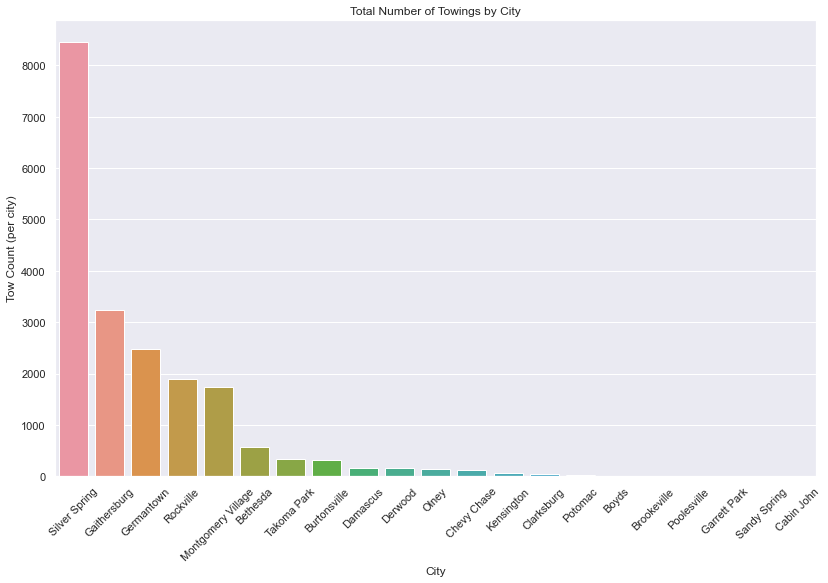

In [10]:
#visualization of towing by city: Chose top 5 to examine further
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x="city", y="tow_count", data = city_uniform)
plt.title("Total Number of Towings by City")
plt.xlabel("City")
plt.ylabel("Tow Count (per city)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

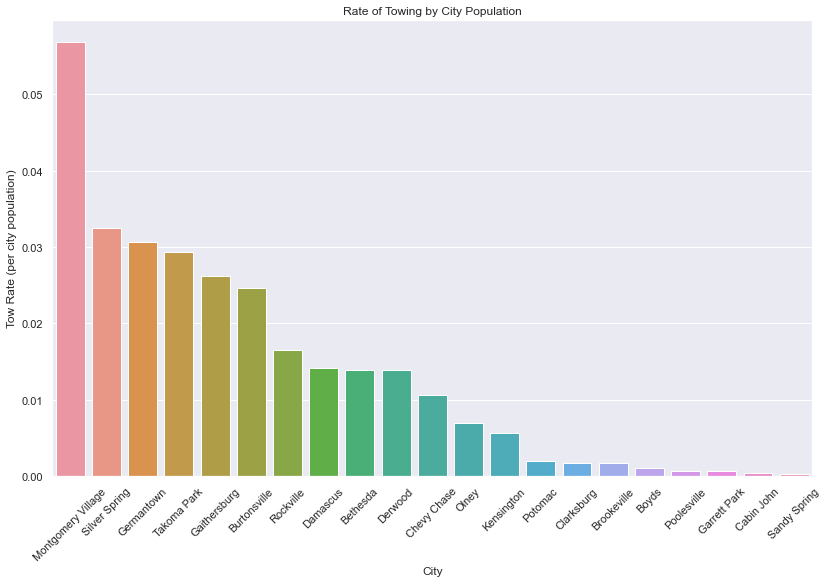

In [11]:
#visualization of towing by city: Chose top 5 to examine further
city_uniform = city_uniform.sort_values(by = ["tow_rate"], ascending=False)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x="city", y="tow_rate", data = city_uniform)
plt.title("Rate of Towing by City Population")
plt.xlabel("City")
plt.ylabel("Tow Rate (per city population)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('city_bar.png')
plt.show()

In [12]:
##WHAT IS THE MOST COMMON REASON FOR TOWING?
tow_code=tow['tow_reason'].value_counts(normalize = True)[tow['tow_reason'].value_counts(normalize = True)> 0.0099]
reason_count = tow["tow_reason"].value_counts()
reason_freq = tow["tow_reason"].value_counts(normalize = True)
print(reason_freq)
tow_code


NOP                                         0.508791
PKG                                         0.204945
PRV                                         0.087653
REPO                                        0.072250
FIRE                                        0.056848
                                              ...   
PK                                          0.000051
EXP PARKING PERMIT                          0.000051
O COMMERCIAL VEH ON PROPERTY  AUTHORIZED    0.000051
PAKRED THE WRONG WAY                        0.000051
RESVERED PKG                                0.000051
Name: tow_reason, Length: 215, dtype: float64


NOP     0.508791
PKG     0.204945
PRV     0.087653
REPO    0.072250
FIRE    0.056848
EXP     0.027056
Name: tow_reason, dtype: float64

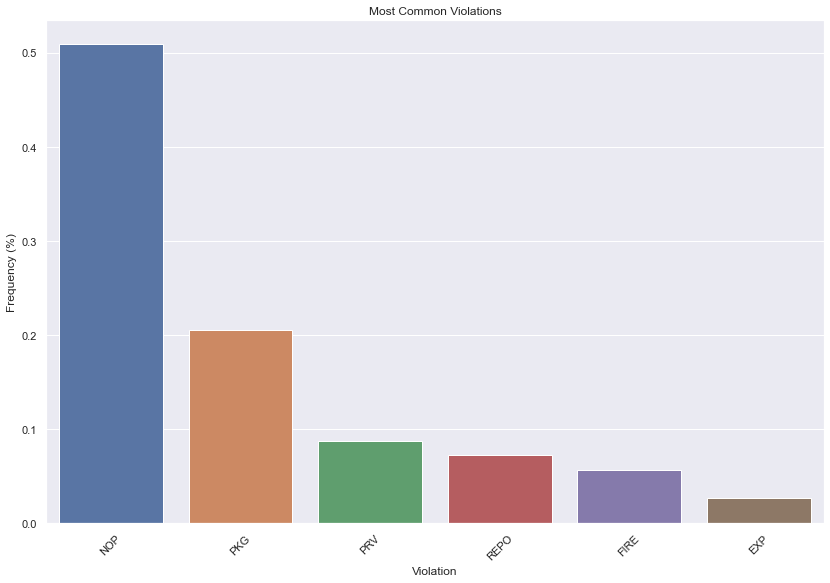

In [13]:
#visualization of towing by reason
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=tow_code.index, y=tow_code)
plt.title("Most Common Violations")
plt.xlabel("Violation")
plt.ylabel("Frequency (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('violation_bar.png')
plt.show()

In [14]:
##WHICH COMPANIES ARE TOWING AND ARE THERE DISCREPANCIES?
tow_company=tow['storage_company'].value_counts(normalize = True)[tow['storage_company'].value_counts(normalize = True)> 0.01]
company_count = tow["storage_company"].value_counts()
company_freq = tow["storage_company"].value_counts(normalize = True)
print(company_freq)
tow_company

Henrys                    0.317302
Authorized                0.161703
Prestige                  0.087350
Speedy                    0.053252
Other                     0.050516
                            ...   
First Class Auto Sales    0.000053
Lnk Recovery              0.000053
Big Toe`                  0.000053
Spedy                     0.000053
Shenandoah                0.000053
Name: storage_company, Length: 264, dtype: float64


Henrys         0.317302
Authorized     0.161703
Prestige       0.087350
Speedy         0.053252
Other          0.050516
Drive          0.044622
Diversified    0.026258
Auburn         0.023206
Big            0.021311
Led            0.012471
Custom         0.012313
Name: storage_company, dtype: float64

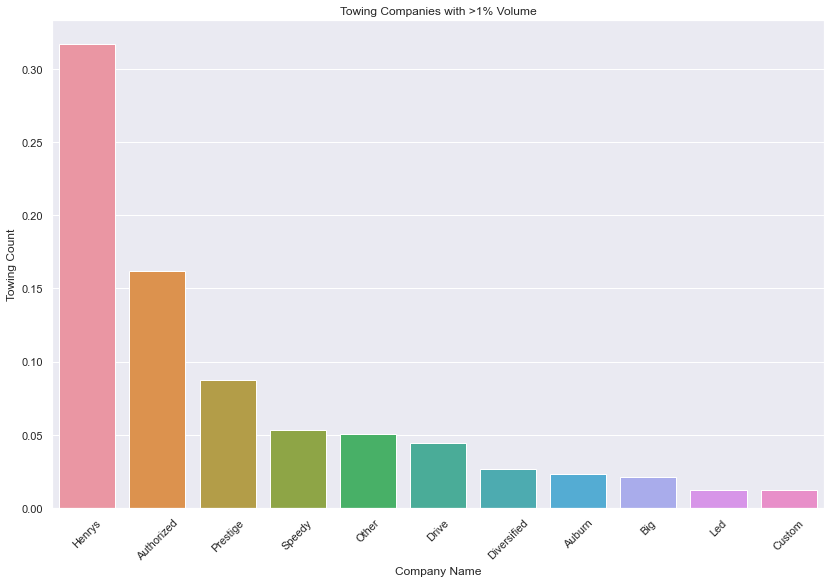

In [15]:
#Visualization of towing by company
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=tow_company.index, y=tow_company)
plt.title("Towing Companies with >1% Volume")
plt.xlabel("Company Name")
plt.ylabel("Towing Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('company_bar.png')
plt.show()

In [16]:
#838 companies still listed as Tcl could not be identified
print(tow[tow["storage_company"] == "Other"])

         tow_date tow_reason storage_company                  street  \
15     2020-08-02        PRV           Other  7501 Muncaster Mill Rd   
16     2020-08-12       FIRE           Other    17612 Phelps Hill Ln   
18     2020-12-20       REPO           Other  6314 Holland Meadow Ln   
21     2021-01-04       REPO           Other         7230 Antares Dr   
84     2020-12-03       REPO           Other        9214 Chadburn Pl   
...           ...        ...             ...                     ...   
19868  2021-01-23       REPO           Other      12122 Bentridge Pl   
19960  2020-08-13        NOP           Other       10524 Westlake Dr   
19964  2020-12-10        NOP           Other       10405 Westlake Dr   
19966  2021-02-01        PKG           Other     10400 Auto Park Ave   
19972  2021-01-23       REPO           Other       10518 Westlake Dr   

                     city                  geo_location  longitude   latitude  \
15           Gaithersburg  POINT (-77.153568 39.153681

In [17]:
#group company for each city - results in multi-index dataframe
grp1 =  tow.groupby(["storage_company", "city"]).agg(count_col=pd.NamedAgg(column="storage_company", aggfunc="count"))     
print(type(grp1))
grp1

<class 'pandas.core.frame.DataFrame'>


count_col
storage_company                 city                         
14505 Lee Hwy                   Silver Spring               1
301-562-4020                    Gaithersburg                1
3018779285                      Silver Spring               1
7908 Bellefonte Ln, Clinton, Md Gaithersburg                1
A &M                            Germantown                  1
...                                                       ...
Westlake                        Germantown                  9
                                Montgomery Village          4
                                Olney                       1
                                Rockville                   5
                                Silver Spring              21

[740 rows x 1 columns]

In [18]:
#flatten above df from multi-index to regular index
grp1 = grp1.reset_index()
grp1

,storage_company,city,count_col
0,14505 Lee Hwy,Silver Spring,1
1,301-562-4020,Gaithersburg,1
2,3018779285,Silver Spring,1
3,"7908 Bellefonte Ln, Clinton, Md",Gaithersburg,1
4,A &M,Germantown,1
...,...,...,...
735,Westlake,Germantown,9
736,Westlake,Montgomery Village,4
737,Westlake,Olney,1
738,Westlake,Rockville,5


In [19]:
#top 8 cities
city_list8 = ['Silver Spring', 'Gaithersburg', 'Germantown', 'Rockville',
        'Montgomery Village', 'Bethesda', 'Burtonsville', 'Takoma Park']
city_list5 = ['Silver Spring', 'Gaithersburg', 'Germantown', 'Rockville','Montgomery Village']

In [20]:
companies = ["Henrys", "Prestige", "Authorized", "Speedy", "Other"]
df5 = grp1.loc[grp1['storage_company'].isin(companies)]
#df5["total"] = int(count_col)
df5 = df5.loc[df5['city'].isin(city_list8)]
df5

,storage_company,city,count_col
99,Authorized,Bethesda,14
100,Authorized,Burtonsville,13
102,Authorized,Gaithersburg,467
103,Authorized,Germantown,411
104,Authorized,Montgomery Village,277
105,Authorized,Rockville,384
106,Authorized,Silver Spring,1467
107,Authorized,Takoma Park,19
373,Henrys,Bethesda,195
375,Henrys,Burtonsville,50


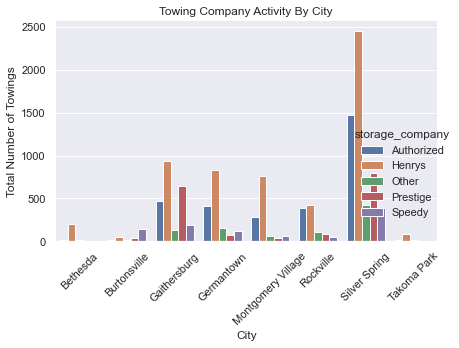

In [21]:
#Visualization of towing by company
sns.set(rc={'figure.figsize':(15.7,12.27)})
sns.catplot(x="city", y="count_col", hue="storage_company", kind="bar", data=df5)
plt.xticks(rotation=45)
plt.title("Towing Company Activity By City")
plt.xlabel("City")
plt.ylabel("Total Number of Towings")
plt.tight_layout()
plt.show()

In [22]:
#COMPARISON OF HOUSEHOLD INCOME BETWEEN CITIES; BOXPLOT FOR TOP 5.

In [23]:
#Create dataframe with demographics and geo only
tow_demo = tow.drop(columns = ["tow_date", "tow_reason", "storage_company", "street", "longitude", "latitude", "location", "tract"])
tow_demo["pop_white"] = tow_demo["pop_total"] - tow_demo["pop_black"]
print(tow_demo.head())
tow_demo.info()

           city                  geo_location    block  hh_income  pop_total  \
0  Gaithersburg  POINT (-77.175624 39.211873)  7001012     208929       1931   
1  Gaithersburg  POINT (-77.167752 39.208712)  7001013     135208        800   
2  Gaithersburg  POINT (-77.148754 39.211605)  7001013     135208        800   
3  Gaithersburg  POINT (-77.141329 39.207148)  7001032     218173       1017   
4  Gaithersburg  POINT (-77.153158 39.166038)  7001033     172778       3112   

   pop_black  state                    geometry  pop_white  
0         39     24  POINT (39.21187 -77.17562)       1892  
1         10     24  POINT (39.20871 -77.16775)        790  
2         10     24  POINT (39.21160 -77.14875)        790  
3        193     24  POINT (39.20715 -77.14133)        824  
4        345     24  POINT (39.16604 -77.15316)       2767  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19753 entries, 0 to 19974
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
-

In [24]:
#show each city demo with count of towing by block in tow_demo
city_grp = tow_demo.groupby(["city", "hh_income", "pop_total", "pop_black", "pop_white"]).agg(count_col=pd.NamedAgg(column="block", aggfunc="count"))
print(city_grp)
city_grp = city_grp.reset_index() #flatten level
#put demo count by city in dataframe "city_df"
citygrp_df = pd.DataFrame(city_grp)
citygrp_df
citygrp_df["tow_rate"] = citygrp_df["count_col"] / citygrp_df["pop_total"]
citygrp_df["black_rate"] = citygrp_df["pop_black"] / citygrp_df["pop_total"]
#we can see that towing decreases as hh_income increases
print(citygrp_df[citygrp_df["city"] == "Germantown"])

                                                     count_col
city        hh_income pop_total pop_black pop_white           
Bethesda    56677     1203      313       890               69
            59205     1032      200       832               67
            62000     892       121       771               35
            64934     1237      221       1016              11
            70132     1335      235       1100               1
...                                                        ...
Takoma Park 98333     1653      467       1186              21
            106875    2104      401       1703              19
            122500    967       46        921                4
            137330    1360      233       1127               5
            152875    1282      273       1009               6

[510 rows x 1 columns]
           city  hh_income  pop_total  pop_black  pop_white  count_col  \
158  Germantown      44784       1505        364       1141        145   
159  Germ

In [25]:
#Calculate IQR and determine inner fences for outliers: ufence = upper fence and lfence = lower fence
citygrp_df.describe()   #to get input values
x = (.024516-.001401)*1.5
lfence = .001401-x
ufence = .024516+x
print(lfence, ufence)

-0.0332715 0.059188500000000005


In [26]:
#Separate into 2 groups(dataframes) top5_demo for top 5 cities, and other_demo for all other cities as a group
#This gives us two independent groups for statistical testing
top5_demo = citygrp_df.loc[citygrp_df['city'].isin(city_list5)]
other_demo = citygrp_df.loc[~citygrp_df['city'].isin(city_list5)]
print(top5_demo.info())
print(top5_demo)
top5_demo.describe()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 83 to 495
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        377 non-null    object 
 1   hh_income   377 non-null    int64  
 2   pop_total   377 non-null    int64  
 3   pop_black   377 non-null    int64  
 4   pop_white   377 non-null    int64  
 5   count_col   377 non-null    int64  
 6   tow_rate    377 non-null    float64
 7   black_rate  377 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 26.5+ KB
None
              city  hh_income  pop_total  pop_black  pop_white  count_col  \
83    Gaithersburg      42212        621         68        553         35   
84    Gaithersburg      47743       1560        263       1297         69   
85    Gaithersburg      50977       1693        416       1277         56   
86    Gaithersburg      54861       1375        585        790          9   
87    Gaithersburg      55037   

,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
count,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000
mean,106245.840849,1871.708223,423.679045,1448.029178,47.206897,0.024610,0.220591
std,41787.914800,927.464480,383.694776,775.362621,78.961340,0.037789,0.168887
min,22628.000000,395.000000,0.000000,80.000000,1.000000,0.000111,0.000000
25%,76630.000000,1239.000000,143.000000,939.000000,2.000000,0.001783,0.096873
50%,98654.000000,1657.000000,324.000000,1310.000000,15.000000,0.008692,0.183754
75%,131833.000000,2371.000000,559.000000,1892.000000,57.000000,0.030740,0.304601
max,250001.000000,8987.000000,2028.000000,7726.000000,500.000000,0.236559,0.933830


<function matplotlib.pyplot.show(close=None, block=None)>

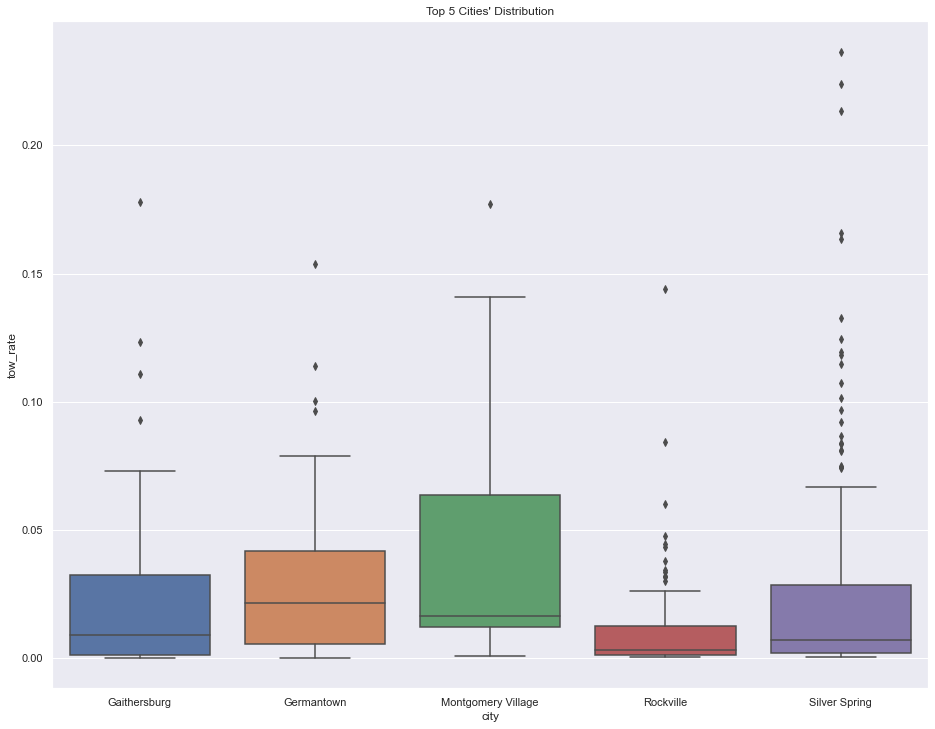

In [27]:
#Show distribution of tow rate for top 5 actively towed cities
sns.boxplot(x = "city", y = "tow_rate", data = top5_demo)
plt.title("Top 5 Cities' Distribution")
plt.savefig('top5_boxplot.png')
plt.show
#Outliers here are important, because they all represent a block(and thus hh_income level) that are towed at higher
#rates than what the expected distribution would indicate

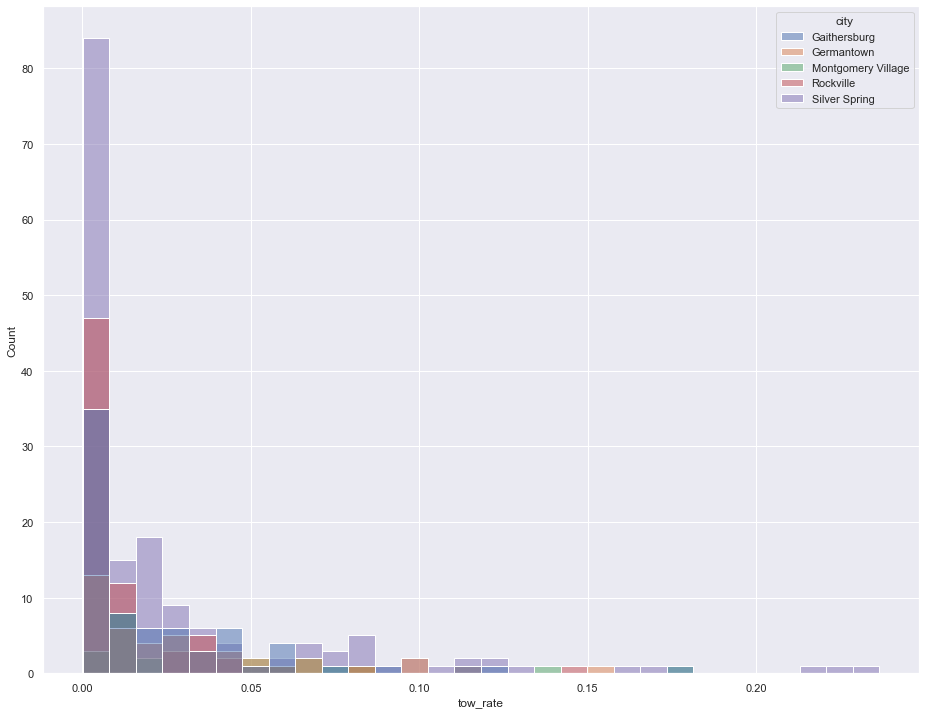

In [28]:
#plot top 5 cities using block data
sns.histplot(x = "tow_rate", hue = "city", data = top5_demo)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

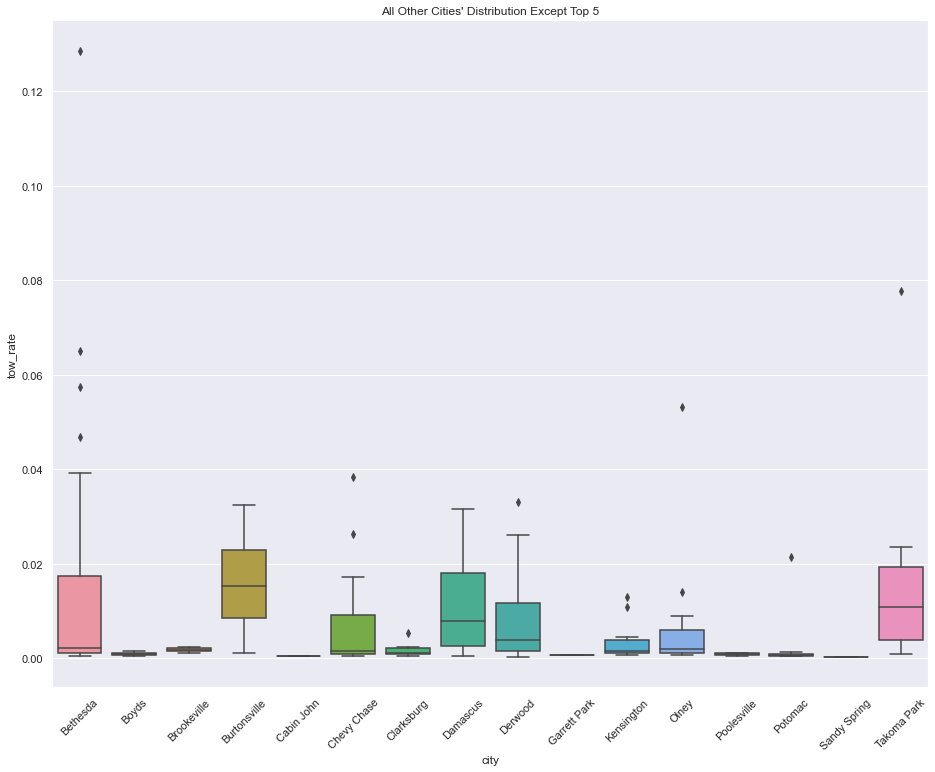

In [29]:
#Show distribution of tow rate for other cities
sns.boxplot(x = "city", y = "tow_rate", data = other_demo)
plt.xticks(rotation=45)
plt.title("All Other Cities' Distribution Except Top 5")
plt.savefig('other_boxplot.png')
plt.show


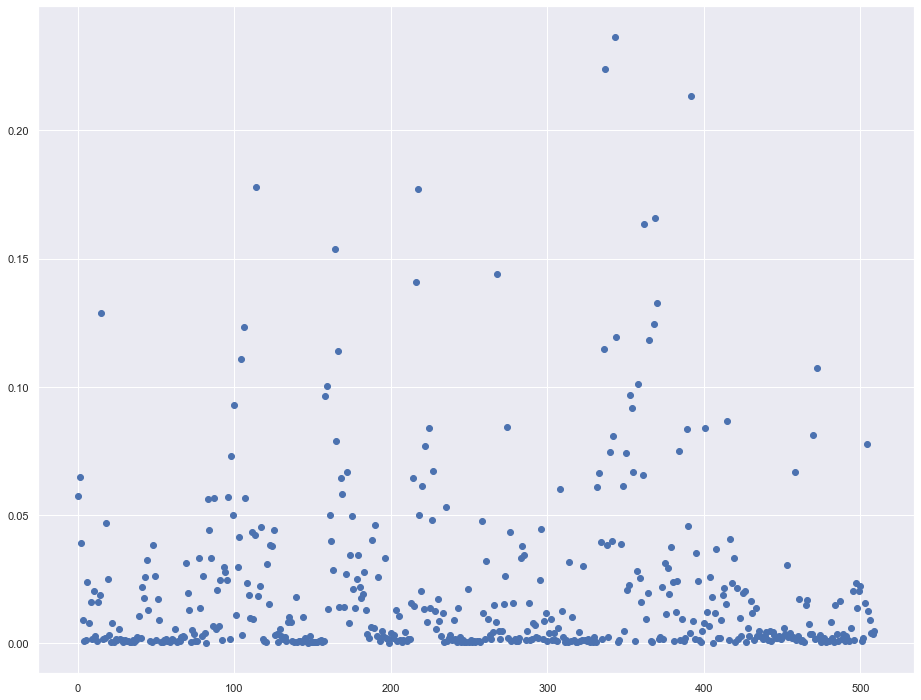

[5.73566085e-02 6.49224806e-02 3.92376682e-02 8.89248181e-03
 7.49063670e-04 1.19331742e-03 2.37331623e-02 8.04649084e-03
 1.60309563e-02 1.52788388e-03 2.05198358e-02 2.74160384e-03
 7.96812749e-04 1.59045726e-02 1.86915888e-02 1.28608924e-01
 1.55038760e-03 2.15982721e-03 4.68018721e-02 2.51827782e-02
 3.22927879e-03 5.49148819e-04 7.89733465e-03 5.51267916e-04
 1.47565175e-03 1.25549278e-03 5.44959128e-03 1.53846154e-03
 1.36892539e-03 5.23560209e-04 1.16009281e-03 8.90471950e-04
 7.51314801e-04 6.45161290e-04 4.63606861e-04 1.41964793e-03
 4.46428571e-04 1.15740741e-03 2.35109718e-03 1.05757932e-02
 2.04813108e-03 2.18052738e-02 1.74833785e-02 2.59917921e-02
 3.24492099e-02 1.29982669e-02 1.00401606e-03 4.71475719e-04
 3.82377390e-02 2.62529833e-02 1.40056022e-03 1.72064777e-02
 9.03342367e-03 6.85400960e-04 5.01756147e-04 1.35135135e-03
 1.61550889e-03 8.07102502e-04 7.75193798e-04 5.76701269e-04
 1.59574468e-03 1.11482720e-03 5.39215686e-03 4.91400491e-04
 8.90174697e-04 8.033741

In [30]:
#Find outliers using Generalized Extreme Test for Outliers (Grubb/Rosner). 
#This test gives us a cutoff value for extreme outliers which are usually wider than the
#IQR calculations.  Test on top 5 cities.
#CODE SOURCE CREDIT to: https://github.com/bhattbhavesh91/outlier-detection-grubbs-test-and-generalized-esd-test-python
#first create array to create scatterplot all tow_rate points in citygrp_df(all cities)
y = np.array(citygrp_df["tow_rate"])
x = np.arange(len(y))
plt.scatter(x,y)
plt.show()
print(y, x)
print(citygrp_df[citygrp_df["tow_rate"] > .17])

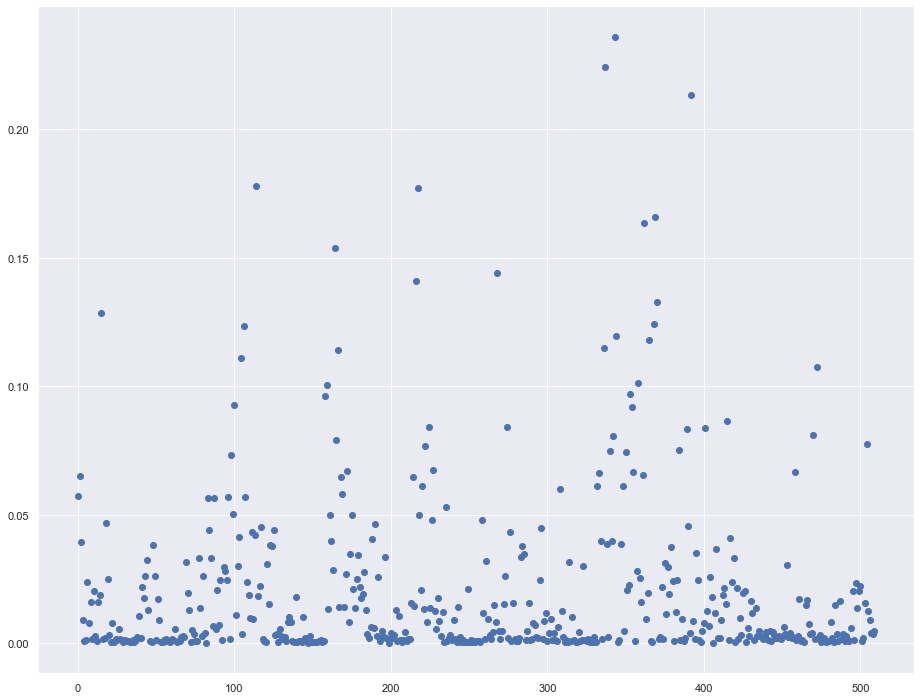

In [31]:
y[337] = 0.224
y[343] = 0.236
plt.scatter(x,y)

In [32]:
def grubbs_stat(y):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    Gcal = max_of_deviations/ std_dev
    print("Grubbs Statistics Value : {}".format(Gcal))
    return Gcal, max_ind

In [33]:
def calculate_critical_value(size, alpha):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    print("Grubbs Critical Value: {}".format(critical_value))
    return critical_value

In [34]:
def check_G_values(Gs, Gc, inp, max_index):
    if Gs > Gc:
        print('{} is an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(inp[max_index], Gs, Gc))
    else:
        print('{} is not an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(inp[max_index], Gs, Gc))

In [35]:
def ESD_Test(input_series, alpha, max_outliers):
    for iterations in range(max_outliers):
        Gcritical = calculate_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)
        check_G_values(Gstat, Gcritical, input_series, max_index)
        input_series = np.delete(input_series, max_index)

In [36]:
ESD_Test(y, 0.05, 30)
#RESULT SHOWS MIN OF .0919 FOR CLASSIFICATION AS OUTLIER

Grubbs Critical Value: 3.8683628857247316
Grubbs Statistics Value : 6.287202262851625
0.236 is an outlier. G > G-critical: 6.2872 > 3.8684 

Grubbs Critical Value: 3.8678444751846253
Grubbs Statistics Value : 6.188432183197559
0.224 is an outlier. G > G-critical: 6.1884 > 3.8678 

Grubbs Critical Value: 3.8673249277101394
Grubbs Statistics Value : 6.108511352935677
0.21343028229255775 is an outlier. G > G-critical: 6.1085 > 3.8673 

Grubbs Critical Value: 3.8668042384778607
Grubbs Statistics Value : 5.191916027186913
0.1779935275080906 is an outlier. G > G-critical: 5.1919 > 3.8668 

Grubbs Critical Value: 3.8662824026344946
Grubbs Statistics Value : 5.307548267274812
0.17699115044247787 is an outlier. G > G-critical: 5.3075 > 3.8663 

Grubbs Critical Value: 3.8657594152958583
Grubbs Statistics Value : 5.0761045956735
0.16567291311754684 is an outlier. G > G-critical: 5.0761 > 3.8658 

Grubbs Critical Value: 3.8652352715464118
Grubbs Statistics Value : 5.134260721427054
0.1633616619452

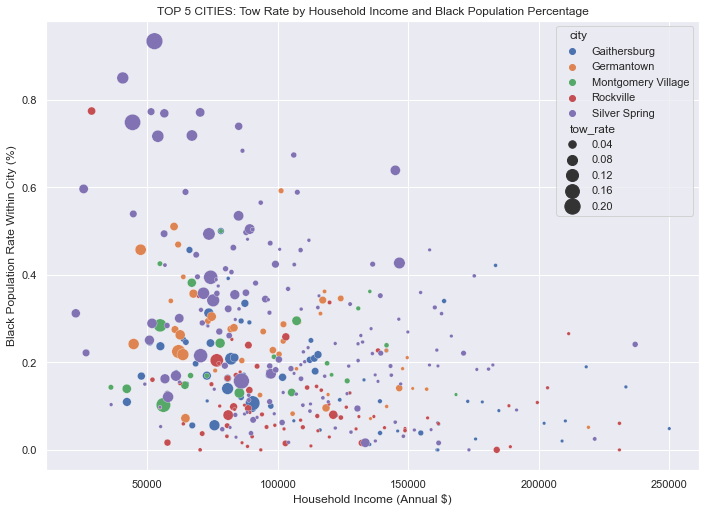

In [37]:
#Set figure size to enlarge for clearer view
sns.set(rc={'figure.figsize':(11.7,8.27)})
#scatterplot(set sizes of tow_rate bubbles)
sns.scatterplot(x='hh_income', y='black_rate', hue = "city", size = "tow_rate", data=top5_demo, sizes=(12, 275))
plt.title("TOP 5 CITIES: Tow Rate by Household Income and Black Population Percentage")
plt.xlabel("Household Income (Annual $)")
plt.ylabel("Black Population Rate Within City (%)")
plt.savefig('bubble.png')
plt.show()
#WE CAN CLEARLY SEE THAT THE LOWER INCOME TOWINGS (RATE = COUNT/CITY POPULATION) APPEAR EXCESSIVE FOR TOP 5 TOWED CITIES
#WE CAN ALSO SEE THE LOWEST INCOME RATES EXPERIENCING EXCESSIVE TOWING ARE AS HIGH AS 80% BLACK POPULATIONS

In [38]:
#Kruskal-Wallis H-test; non-parametric analysis of variance: H-0: medians are the same vs H_alpha
# with alpha = .05: the medians differ
x = top5_demo["tow_rate"]
y = other_demo["tow_rate"]
stats.kruskal(x, y)
#Result suggests we can very strongly reject the null hypothesis that the medians are the same; seems to confirm
#boxplot view

KruskalResult(statistic=30.263402933228402, pvalue=3.7717583344577394e-08)

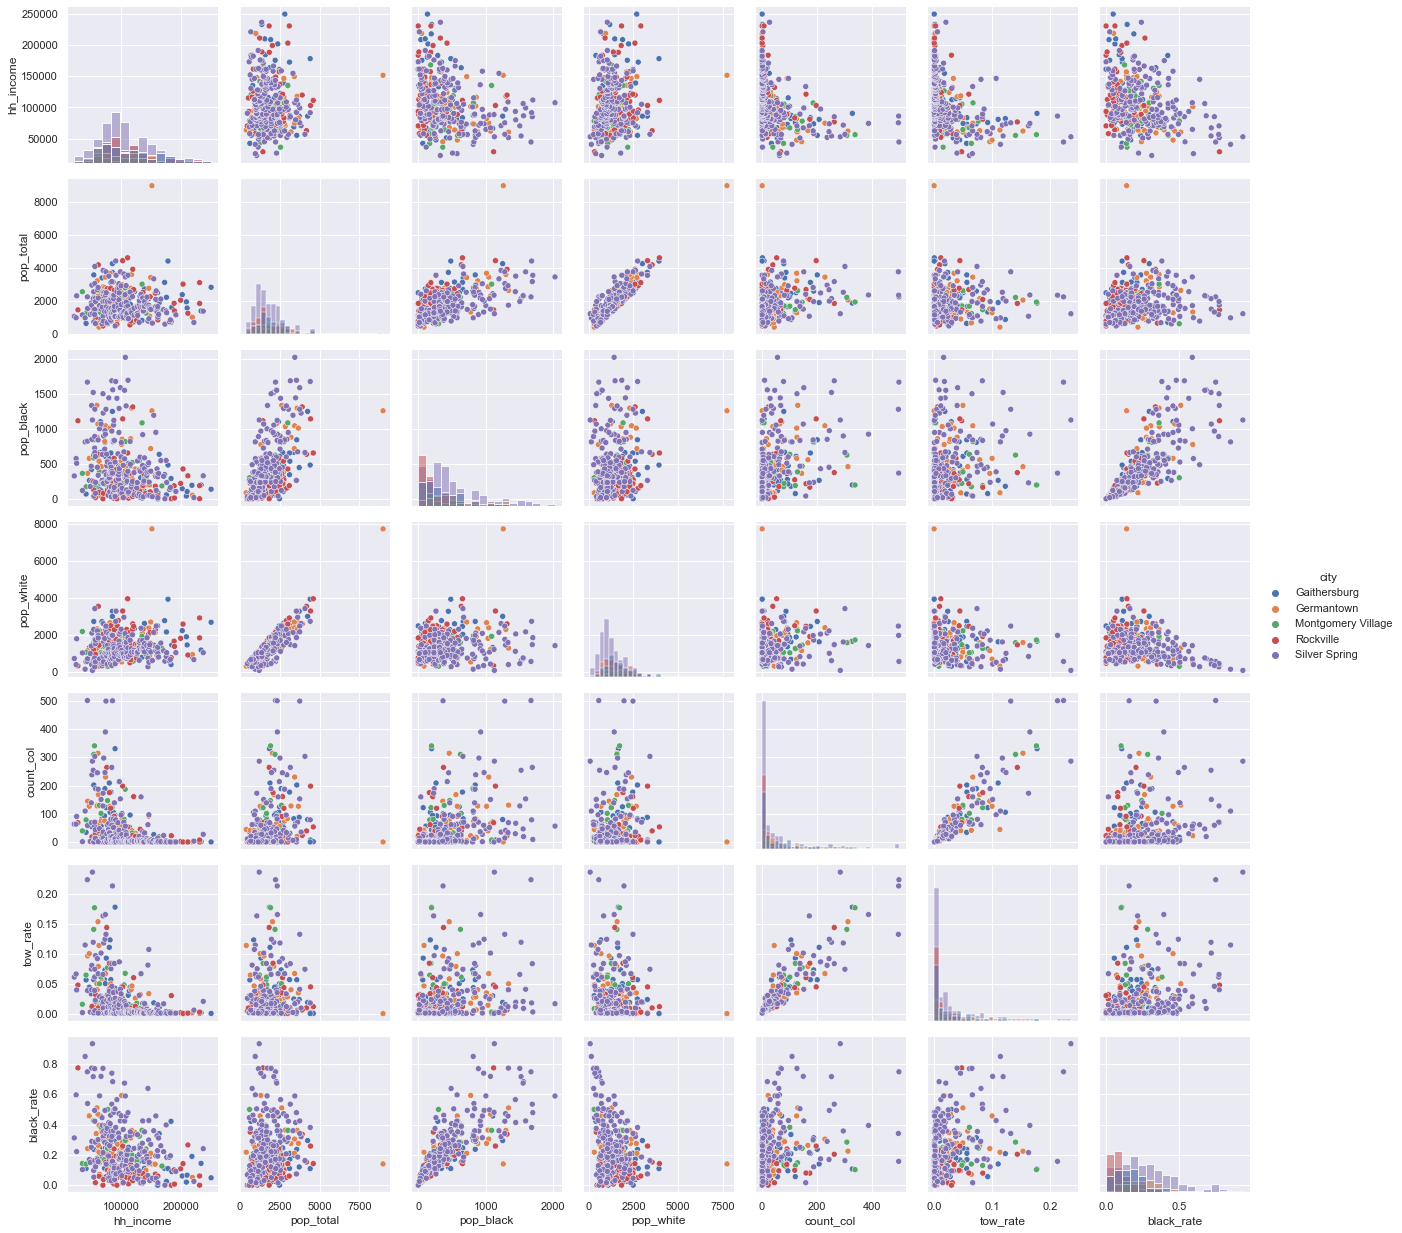

In [39]:
#look at correlations between pairs of variables
g = sns.PairGrid(top5_demo, hue="city")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
#population totals and breakdowns have linear correlation as would be expected
#black rate seems to show high tow rates in some areas even in upper incomes; white_rate seems to have a cutoff
#where whites of a certain income no longer experience towing at all

In [40]:
#Independent dataframes by city for block drilldown on demographics
btc = citygrp_df[citygrp_df['city']=="Bethesda"]
btb = citygrp_df[citygrp_df['city']=="Burtonsville"]
gbc = citygrp_df[citygrp_df['city']=="Gaithersburg"]
gtc = citygrp_df[citygrp_df['city']=="Germantown"]
mvc = citygrp_df[citygrp_df['city']=="Montgomery Village"]
rvc = citygrp_df[citygrp_df['city']=="Rockville"]
ssc = citygrp_df[citygrp_df['city']=="Silver Spring"]
tpc = citygrp_df[citygrp_df["city"]=="Takoma Park"]
print(sum(ssc["tow_rate"]))
gbc


4.389748420500897


,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
83,Gaithersburg,42212,621,68,553,35,0.056361,0.109501
84,Gaithersburg,47743,1560,263,1297,69,0.044231,0.168590
85,Gaithersburg,50977,1693,416,1277,56,0.033077,0.245718
86,Gaithersburg,54861,1375,585,790,9,0.006545,0.425455
87,Gaithersburg,55037,3568,845,2723,202,0.056614,0.236827
...,...,...,...,...,...,...,...,...
152,Gaithersburg,208929,1931,39,1892,1,0.000518,0.020197
153,Gaithersburg,210179,1557,103,1454,1,0.000642,0.066153
154,Gaithersburg,218173,1017,193,824,1,0.000983,0.189774
155,Gaithersburg,233362,1376,198,1178,2,0.001453,0.143895


In [41]:
#HEATMAPS OF TOP 5 CITIES SHOW PROBLEM AREAS

gtc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})

,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
158,Germantown,44784,1505,364,1141,145,0.096346,0.241860
159,Germantown,47472,1266,579,687,127,0.100316,0.457346
160,Germantown,59033,1880,640,1240,25,0.013298,0.340426
161,Germantown,60268,2624,1339,1285,131,0.049924,0.510290
162,Germantown,60625,3207,882,2325,128,0.039913,0.275023
163,Germantown,61838,2285,1072,1213,65,0.028446,0.469147
164,Germantown,62000,2043,459,1584,314,0.153696,0.224670
165,Germantown,62614,2127,559,1568,168,0.078984,0.262811
166,Germantown,63659,395,86,309,45,0.113924,0.217722
167,Germantown,63819,1361,538,823,19,0.013960,0.395298


In [42]:
gbc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})

,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
83,Gaithersburg,42212,621,68,553,35,0.056361,0.109501
84,Gaithersburg,47743,1560,263,1297,69,0.044231,0.168590
85,Gaithersburg,50977,1693,416,1277,56,0.033077,0.245718
86,Gaithersburg,54861,1375,585,790,9,0.006545,0.425455
87,Gaithersburg,55037,3568,845,2723,202,0.056614,0.236827
88,Gaithersburg,61154,887,158,729,5,0.005637,0.178129
89,Gaithersburg,63824,1551,392,1159,32,0.020632,0.252740
90,Gaithersburg,64429,2604,385,2219,18,0.006912,0.147849
91,Gaithersburg,64805,2685,661,2024,66,0.024581,0.246182
92,Gaithersburg,65368,869,132,737,1,0.001151,0.151899


In [43]:
mvc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})

,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
213,Montgomery Village,36071,2545,364,2181,40,0.015717,0.143026
214,Montgomery Village,42159,1225,171,1054,79,0.064490,0.139592
215,Montgomery Village,54861,1375,585,790,20,0.014545,0.425455
216,Montgomery Village,54931,2201,626,1575,310,0.140845,0.284416
217,Montgomery Village,56188,1921,197,1724,340,0.176991,0.102551
218,Montgomery Village,64429,2604,385,2219,130,0.049923,0.147849
219,Montgomery Village,66591,1266,215,1051,26,0.020537,0.169826
220,Montgomery Village,67071,1668,637,1031,102,0.061151,0.381894
221,Montgomery Village,72841,1634,277,1357,22,0.013464,0.169523
222,Montgomery Village,77917,1915,467,1448,147,0.076762,0.243864


In [44]:
rvc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})

,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
258,Rockville,28681,1444,1118,326,69,0.047784,0.774238
259,Rockville,52000,1590,255,1335,19,0.011950,0.160377
260,Rockville,54891,1311,127,1184,2,0.001526,0.096873
261,Rockville,57750,964,16,948,31,0.032158,0.016598
262,Rockville,62548,4180,638,3542,40,0.009569,0.152632
263,Rockville,63824,1531,91,1440,5,0.003266,0.059438
264,Rockville,69659,639,224,415,1,0.001565,0.350548
265,Rockville,70250,464,0,464,2,0.004310,0.000000
266,Rockville,71063,2123,79,2044,32,0.015073,0.037211
267,Rockville,74596,2625,394,2231,22,0.008381,0.150095


In [45]:
ssc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '10px'})



,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
332,Silver Spring,22628,1048,327,721,64,0.061069,0.312023
333,Silver Spring,25636,966,576,390,64,0.066253,0.596273
334,Silver Spring,26563,2296,509,1787,91,0.039634,0.221690
335,Silver Spring,36172,1141,118,1023,2,0.001753,0.103418
336,Silver Spring,40625,959,815,144,110,0.114703,0.849844
337,Silver Spring,44375,2234,1672,562,500,0.223814,0.748433
338,Silver Spring,44662,1532,826,706,59,0.038512,0.539164
339,Silver Spring,49070,1165,175,990,3,0.002575,0.150215
340,Silver Spring,50843,1863,467,1396,139,0.074611,0.250671
341,Silver Spring,51477,1730,1337,393,69,0.039884,0.772832


In [46]:
#TEST IF INCOME IN PAIRED CITIES HAVE THE SAME DISTRIBUTION OR ARE DIFFERENT
#H_0: THEY HAVE THE SAME DISTRIBUTIONS
#H_alpha: THEY HAVE DIFFERENT DISTRIBUTIONS
#alpha = 0.95

#FOR GERMANTOWN: Montgomery Village, alpha > 0.05; cannot reject the null 
#FOR GERMANTOWN: Gaithersburg, Rockville, Silver Spring, alpha < 0.05; reject the null

In [47]:
#Mann Whitney U Test:  GERMANTOWN
import scipy.stats
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(gbc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=1209.0, pvalue=0.00992940244930318)

In [48]:
scipy.stats.mannwhitneyu(mvc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=435.0, pvalue=0.2547179195727841)

In [49]:
scipy.stats.mannwhitneyu(rvc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=828.0, pvalue=6.076058021587579e-06)

In [50]:
scipy.stats.mannwhitneyu(ssc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=2700.0, pvalue=0.005235736244517493)

In [51]:
#Mann Whitney U Test ; GAITHERSBURG 

#For Gaithersburg: Rockville, Silver Spring, alpha > 0.05; cannot reject the null 
#For Gaithersburg: Montgomery Village, Germantown; reject the null
scipy.stats.mannwhitneyu(mvc["tow_rate"], gbc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=522.0, pvalue=0.005525737109465313)

In [52]:
scipy.stats.mannwhitneyu(rvc["tow_rate"], gbc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=2310.5, pvalue=0.06540174779174178)

In [53]:
scipy.stats.mannwhitneyu(ssc["tow_rate"], gbc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=5808.5, pvalue=0.2991628380829954)

In [54]:
#Mann Whitney U Test ; MONTGOMERY VILLAGE
#For Montgomery Village:  Germantown, alpha > 0.05; cannot reject the null 
#For Montgomery Village: Rockville, Silver Spring, Gaithersburg.    reject the null
scipy.stats.mannwhitneyu(rvc["tow_rate"], mvc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=334.0, pvalue=1.7883349309378526e-05)

In [55]:
scipy.stats.mannwhitneyu(ssc["tow_rate"], mvc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=1203.0, pvalue=0.0056625887737787395)

In [56]:
#Mann Whitney U Test ; ROCKVILLE
#For Rockville: Gaithersburg    alpha > 0.05; cannot reject the null 
#For Rockville: Montgomery Village, Silver Spring, Germantown;    reject the null
scipy.stats.mannwhitneyu(ssc["tow_rate"], rvc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=4685.0, pvalue=0.003805204375142309)

In [57]:
#Mann Whitney U Test ; SILVER SPRING
#For Silver Spring:  Gaithersburg ;    alpha > 0.05; cannot reject the null 
#For Silver Spring: Rockville, Montgomery Village, Germantown;    reject the null

In [58]:
#LOGISTIC REGRESSION

In [59]:
print(top5_demo.describe())
city_uniform.describe()

           hh_income    pop_total    pop_black    pop_white   count_col  \
count     377.000000   377.000000   377.000000   377.000000  377.000000   
mean   106245.840849  1871.708223   423.679045  1448.029178   47.206897   
std     41787.914800   927.464480   383.694776   775.362621   78.961340   
min     22628.000000   395.000000     0.000000    80.000000    1.000000   
25%     76630.000000  1239.000000   143.000000   939.000000    2.000000   
50%     98654.000000  1657.000000   324.000000  1310.000000   15.000000   
75%    131833.000000  2371.000000   559.000000  1892.000000   57.000000   
max    250001.000000  8987.000000  2028.000000  7726.000000  500.000000   

         tow_rate  black_rate  
count  377.000000  377.000000  
mean     0.024610    0.220591  
std      0.037789    0.168887  
min      0.000111    0.000000  
25%      0.001783    0.096873  
50%      0.008692    0.183754  
75%      0.030740    0.304601  
max      0.236559    0.933830  


,tow_count,pop_black,pop_total,pop_white,tow_rate
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,940.619048,8154.190476,38096.809524,29942.619048,0.013841
std,1958.585088,17915.625386,61944.513025,45137.203801,0.014881
min,1.000000,10.000000,1383.000000,1373.000000,0.000321
25%,6.000000,655.000000,5762.000000,5008.000000,0.001664
50%,143.000000,1247.000000,11725.000000,10315.000000,0.010576
75%,561.000000,6320.000000,30577.000000,24146.000000,0.024634
max,8455.000000,81106.000000,260036.000000,178930.000000,0.056840


In [60]:
#For p(i) as probability of being towed GET p1, p2, p3, p4, p5 FOR THE TOP 5 TO COMPARE H_O: all equal, or H_alph: at least one is not equal; alpha = .05
#then compare overall p1+p2+p3+p4+p5 to all others combined; remember probability of not being towed in a given area i is 1-p(i)
p1 = round(city_uniform.iloc[2,5], 4)
p2 = round(city_uniform.iloc[1,5], 4)
p3 = round(city_uniform.iloc[3,5], 4)
p4 = round(city_uniform.iloc[5,5], 4)
p5 = round(city_uniform.iloc[4,5], 4)
print("Gaithersburg is p1 = ", p1)
print("Silver Spring is p2 = ", p2)
print("Germantown is p3 = ", p3)
print("Montgomery Village is p4 = ", p4)
print("Rockville is p5 = ", p5)

p_top5 = round((p1+p2+p3+p4+p5), 4)
print("p_top5 = ", p_top5)
sum_all = city_uniform["tow_rate"].sum()
sum_all = round(sum_all, 4)
p_other = round(sum_all - p_top5, 4)
print('p_other = ', p_other)
#OVERALL RESULT BETWEEN THE 2 GROUPS IS CLOSE: perform bayesian analysis of two groups, using p_top5, p_other along 
#with n_top5, n_other where n is the number of choices = population being considered(eg. top5 and total-top5 block population totals)

Gaithersburg is p1 =  0.0306
Silver Spring is p2 =  0.0325
Germantown is p3 =  0.0294
Montgomery Village is p4 =  0.0246
Rockville is p5 =  0.0263
p_top5 =  0.1434
p_other =  0.1473


In [61]:
#count total number of observations(rows)
n_top5 = len(tow.loc[tow["city"].isin(city_list5)])
n_other = len(tow.loc[~tow["city"].isin(city_list5)])
print("n_top5 = ", n_top5)
print("n_other = ", n_other)

n_top5 =  17797
n_other =  1956


In [62]:
#Perform t-test to compare means of each group: large n, independent
from scipy.stats import ttest_ind_from_stats
ttest_ind_from_stats(mean1=0.024508, std1=np.sqrt(0.037641), nobs1=n_top5,
                     mean2=0.013582, std2=np.sqrt(.01420), nobs2=n_other)
#alpha <0.05; reject null H_0: u_top5 = u_other
#The means are different between the top 5 cities as a group compared against all others as a group; 
#the difference appears mildly significant.



Ttest_indResult(statistic=2.440548818867342, pvalue=0.01467368961943033)

In [63]:
#now examine block groups which all have an average household income associated with each block

In [64]:
block_grp =  tow_demo.groupby(["block", "city", "hh_income", "pop_total", "pop_black", "pop_white", "geo_location"]).agg(count_col=pd.NamedAgg(column="block", aggfunc="count"))
block_grp = block_grp.reset_index()
#put demo count by city in dataframe "block_df"
block_df = pd.DataFrame(block_grp).copy()
block_df["tow_rate"] = block_df["count_col"] / block_df["pop_total"]

block_df.to_csv('/Users/elizabethclick/Desktop/DATA205/block_df.csv', index = False)
block_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   block         5881 non-null   int64  
 1   city          5881 non-null   object 
 2   hh_income     5881 non-null   int64  
 3   pop_total     5881 non-null   int64  
 4   pop_black     5881 non-null   int64  
 5   pop_white     5881 non-null   int64  
 6   geo_location  5881 non-null   object 
 7   count_col     5881 non-null   int64  
 8   tow_rate      5881 non-null   float64
dtypes: float64(1), int64(6), object(2)
memory usage: 413.6+ KB


In [65]:
#INVESTIGATE NEIGHBORHOODS WITH TOW RATES >=10.7%; this is the outlier cutoff; we get 500 rows(blocks)
#7015051 block is The Enclave Apartments at 11225 Oak Leaf Dr, Silver Spring
#7032141 block is Cinnamon Run at Peppertree Farms, 14120 Weeping Willow Dr, Aspen Hill?, not SS?
#7014222 block is Woodvale Apartments, 13831 Castle Blvd., Silver Spring, MD, Windsor Court and Tower Apartments,
#13802 Castle Blvd

print("These blocks have tow rates >= 9.19%:  ")
print(block_df[block_df["tow_rate"] >= .0919])


These blocks have tow rates >= 9.19%:  
        block           city  hh_income  pop_total  pop_black  pop_white  \
1501  7007233   Gaithersburg      82083        860        179        681   
2480  7008172   Gaithersburg      90385       1854        198       1656   
2572  7008182     Germantown      62000       2043        459       1584   
4054  7014222  Silver Spring      52768       1209       1129         80   
4175  7015051  Silver Spring      44375       2234       1672        562   
5148  7032133  Silver Spring      70446       1059        228        831   
5163  7032141  Silver Spring      86071       2338        368       1970   

                      geo_location  count_col  tow_rate  
1501  POINT (-77.195077 39.144489)         81  0.094186  
2480  POINT (-77.201438 39.114884)        300  0.161812  
2572  POINT (-77.261484 39.179888)        273  0.133627  
4054  POINT (-76.942666 39.083117)        161  0.133168  
4175  POINT (-76.995468 39.040254)        435  0.194718  
514

In [66]:
#May want to look at >=upper fence by looking at the IQR and using computed ufence = 0.0648215
print("These blocks have tow rates >= 0.0648215  ")
print(block_df[block_df["tow_rate"] >= ufence])
#print(tow[tow["block"] == 7015051], "is at", tow[tow["street"], tow[tow["city"]]])   


#print(tow[tow["block"] == 7032141], )
#print(tow[tow["block"] == 7014222], )

These blocks have tow rates >= 0.0648215  
        block           city  hh_income  pop_total  pop_black  pop_white  \
1486  7007232   Gaithersburg      75750       1315         74       1241   
1501  7007233   Gaithersburg      82083        860        179        681   
2480  7008172   Gaithersburg      90385       1854        198       1656   
2572  7008182     Germantown      62000       2043        459       1584   
2769  7008221   Gaithersburg      80781       1886        264       1622   
3152  7009041      Rockville      76630       1834        375       1459   
3807  7014172  Silver Spring      67109       1491       1071        420   
4054  7014222  Silver Spring      52768       1209       1129         80   
4058  7014222  Silver Spring      52768       1209       1129         80   
4175  7015051  Silver Spring      44375       2234       1672        562   
4215  7015081  Silver Spring      56550       1160        892        268   
4274  7015083  Silver Spring      54063      

In [67]:
#LOGISTIC REGRESSION

In [68]:
#Create new column "redzone" in block_df with 0 negative, 1 positive: positive = tow rate >=0.05; negative = tow_rate<0.05
#Use features: block, hh_income, black_rate, population and target: redzone
block_lr = block_df.copy() 
block_lr["black_rate"] = block_lr["pop_black"] / block_lr["pop_total"]

In [69]:
lr_grp =  block_lr.groupby(["block", "pop_total", "hh_income", "black_rate"]).agg(count_col=pd.NamedAgg(column="count_col", aggfunc="sum"))
lr_grp = lr_grp.reset_index()
#put demo count by city in dataframe "block_df"
lr_df = pd.DataFrame(lr_grp).copy()
#block_df["tow_rate"] = block_df["count_col"] / block_df["pop_total"]
lr_df
#initialize column at negative - 0
lr_df["tow_rate"] = lr_df["count_col"] / lr_df["pop_total"]
lr_df["redzone"] = 0
lr_df.info()
print(lr_df.shape)
for i in range(lr_df.shape[0]) :
    if lr_df.iloc[i,5] < 0.05 :
        lr_df.iloc[i,6] = 0
    else :
        lr_df.iloc[i,6] = 1

lr_df = lr_df.drop(columns = ["block", "count_col", "pop_total", "tow_rate"])
lr_df.tail(50)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   block       470 non-null    int64  
 1   pop_total   470 non-null    int64  
 2   hh_income   470 non-null    int64  
 3   black_rate  470 non-null    float64
 4   count_col   470 non-null    int64  
 5   tow_rate    470 non-null    float64
 6   redzone     470 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 25.8 KB
(470, 7)


,hh_income,black_rate,redzone
420,150833,0.047887,0
421,98600,0.177268,0
422,150625,0.000000,0
423,188393,0.024096,0
424,171683,0.044481,0
425,216923,0.042916,0
426,85865,0.041052,0
427,216250,0.030132,0
428,64934,0.178658,0
429,161771,0.041981,0


In [70]:
#IMPLEMENT LR MODEL: TARGET = REDZONE
#We note minority class is the positive of our target variable
lr_df['redzone'].value_counts()
#high tow rates are a minority class by the numbers shown below, and we may need to try SMOTE after LR is applied

0    407
1     63
Name: redzone, dtype: int64

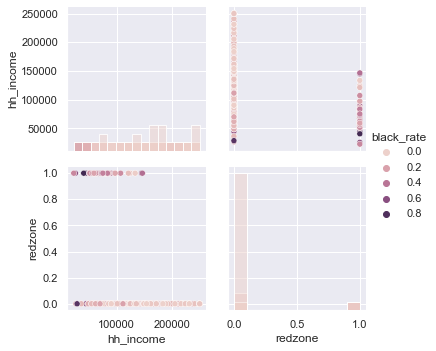

In [71]:
#Look at correlation pairplots
g = sns.PairGrid(lr_df, hue="black_rate")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
g
#no linear correlation noted - do not drop any variables from our model at this point

In [72]:
corr = lr_df.corr()
corr.style.background_gradient(cmap='coolwarm')
#confirms pairplots

,hh_income,black_rate,redzone
hh_income,1.000000,-0.423310,-0.346496
black_rate,-0.423310,1.000000,0.271694
redzone,-0.346496,0.271694,1.000000


In [73]:
#Create features and target pandas using lr_df dataset, and "redzone" as the target variable
X = lr_df.iloc[:,0:-1] 
y = lr_df["redzone"]

#check X to verify that target column has been removed and only features remain
X.head()

,hh_income,black_rate
0,208929,0.020197
1,135208,0.012500
2,218173,0.189774
3,172778,0.110861
4,118906,0.197785


In [74]:
#Break data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=0)

In [75]:
#Call to apply model
LogReg = LogisticRegression()


scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LogReg.fit(X_train,y_train)


y_pred=LogReg.predict(X_test)

In [76]:
print('Classes', LogReg.classes_)
print('Intercept',LogReg.intercept_)
print("Coefficients", LogReg.coef_ )

Classes [0 1]
Intercept [-2.95199313]
Coefficients [[-2.02543674  0.15917887]]


In [77]:
print("Accuracy", LogReg.score(X_test, y_test))
print(classification_report(y_test, LogReg.predict(X_test)))

Accuracy 0.8723404255319149
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       121
           1       0.75      0.15      0.25        20

    accuracy                           0.87       141
   macro avg       0.81      0.57      0.59       141
weighted avg       0.86      0.87      0.83       141



In [78]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[120,   1],
       [ 17,   3]])

Text(0.5, 527.9871999999999, 'Predicted label')

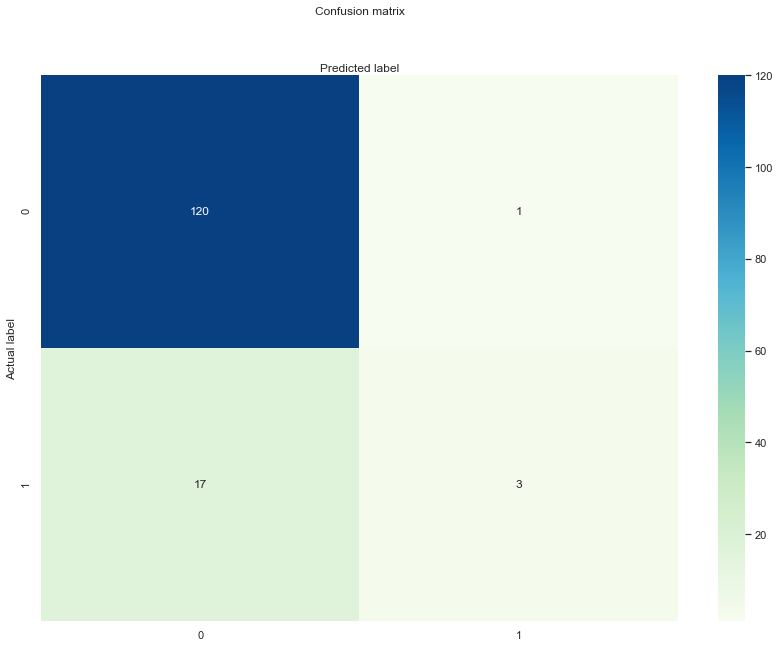

In [79]:
categories = [0,1] 
fig, ax = plt.subplots()
plt.xticks([0,1], categories)
plt.yticks([0,1], categories)
# create heatmap
sns.heatmap(pd.DataFrame(conf_mat), annot=True, cmap="GnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#We will catch  3 but miss 17 of the "at_risk" category ---> likely unacceptable to miss so many at risk BUT will get most egregious
#We will show 120 but miss 1  of the "no risk" category ----> highly accurate for majority class

In [80]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.8723404255319149
Precision: 0.75
Recall: 0.15


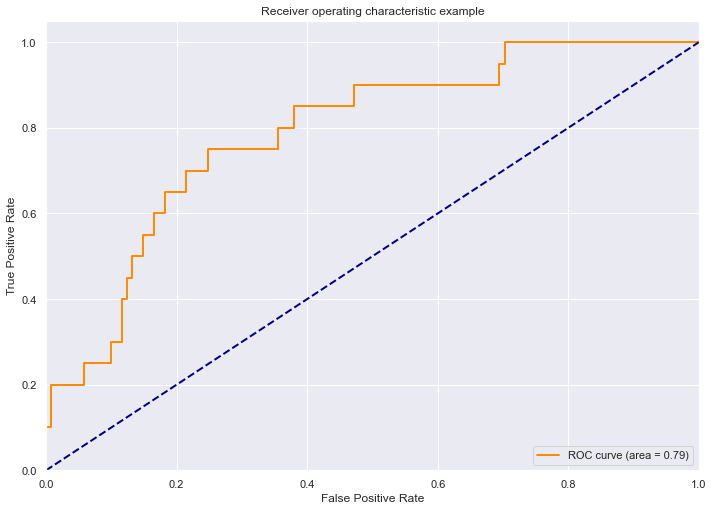

In [81]:
y_pred_proba = LogReg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show() 
#0.79 ROC value indicates the model is good at predicting "no risk", but the "at risk" areas are not reported as easily
#although the most egregious 3 areas may be found here.
##Unable to try using SMOTE in order to increase "at risk" minority group due to package conflicts

In [82]:
#combine all block data for top5 into their respective cities
btb = block_df[block_df['city']=="Bethesda"]
bvb = block_df[block_df['city']=="Burtonsville"]
gbb = block_df[block_df['city']=="Gaithersburg"]
gtb = block_df[block_df['city']=="Germantown"]
mvb = block_df[block_df['city']=="Montgomery Village"]
rvb = block_df[block_df['city']=="Rockville"]
ssb = block_df[block_df['city']=="Silver Spring"]
tpb = block_df[block_df['city']=="Takoma Park"]
print("Gaithersburg", gbb.describe())
print("Germantown", gtb.describe())
print("Montgomery_Village", mvb.describe())
print("Rockville", rvb.describe())
print("Silver Spring", ssb.describe())
btb


Gaithersburg               block      hh_income    pop_total    pop_black    pop_white  \
count  9.480000e+02     948.000000   948.000000   948.000000   948.000000   
mean   7.007267e+06   91414.474684  2265.200422   433.541139  1831.659283   
std    1.334212e+03   29544.319504   808.635665   260.124967   660.236317   
min    7.001012e+06   42212.000000   602.000000     0.000000   301.000000   
25%    7.007161e+06   73580.000000  1634.000000   235.000000  1310.000000   
50%    7.007201e+06   85966.000000  2231.000000   370.000000  1776.000000   
75%    7.008161e+06  103092.000000  2722.000000   608.000000  2284.000000   
max    7.013071e+06  250001.000000  4606.000000  1252.000000  3950.000000   

        count_col    tow_rate  
count  948.000000  948.000000  
mean     3.409283    0.001753  
std     13.451905    0.007458  
min      1.000000    0.000217  
25%      1.000000    0.000401  
50%      1.000000    0.000597  
75%      2.000000    0.001082  
max    300.000000    0.161812  
Germa

,block,city,hh_income,pop_total,pop_black,pop_white,geo_location,count_col,tow_rate
3315,7012053,Bethesda,124554,762,33,729,POINT (-77.126068 39.025879),20,0.026247
3316,7012053,Bethesda,124554,762,33,729,POINT (-77.126521 39.0286),1,0.001312
3317,7012053,Bethesda,124554,762,33,729,POINT (-77.127605 39.029056),2,0.002625
3318,7012053,Bethesda,124554,762,33,729,POINT (-77.127756 39.029152),3,0.003937
3319,7012053,Bethesda,124554,762,33,729,POINT (-77.128016 39.029317),38,0.049869
...,...,...,...,...,...,...,...,...,...
5876,7060123,Bethesda,59205,1032,200,832,POINT (-77.149295 39.024606),14,0.013566
5877,7060123,Bethesda,59205,1032,200,832,POINT (-77.152166 39.026407),1,0.000969
5878,7060123,Bethesda,59205,1032,200,832,POINT (-77.152171 39.026405),13,0.012597
5879,7060123,Bethesda,59205,1032,200,832,POINT (-77.152785 39.026129),1,0.000969


Text(0, 0.5, 'Household Income')

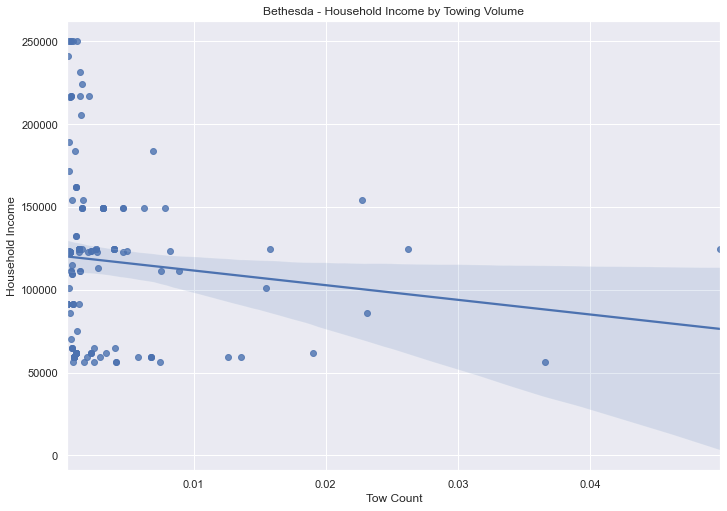

In [83]:
#none of these regression plots, show that a Linear Regression Model would work, but it does help to see that
#the slope of the line indicates towing rates increase as income decreases
sns.regplot(x = "tow_rate", y = "hh_income", data = btb)
plt.title("Bethesda - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

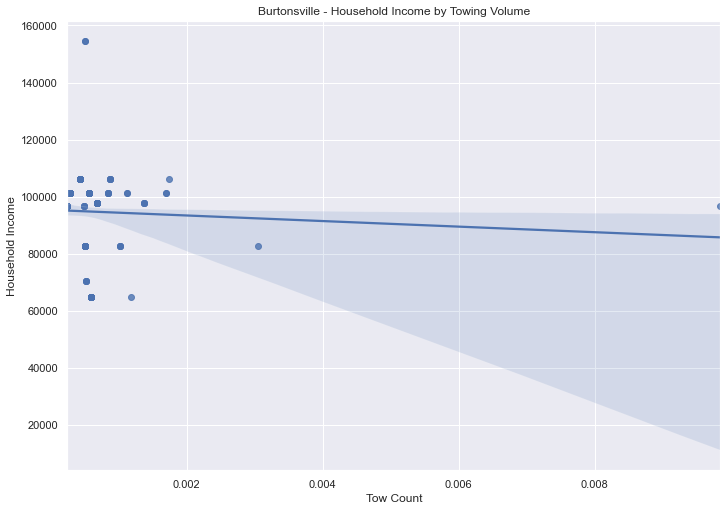

In [84]:
sns.regplot(x = "tow_rate", y = "hh_income", data = bvb)
plt.title("Burtonsville - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

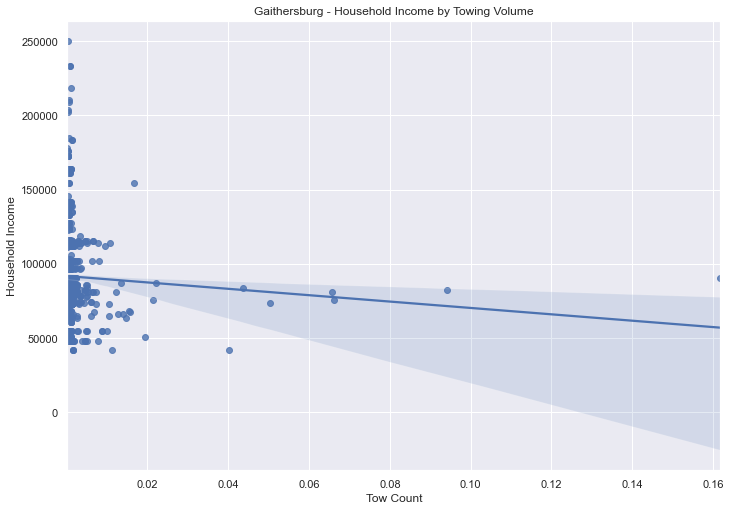

In [85]:
sns.regplot(x = "tow_rate", y = "hh_income", data = gbb)
plt.title("Gaithersburg - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

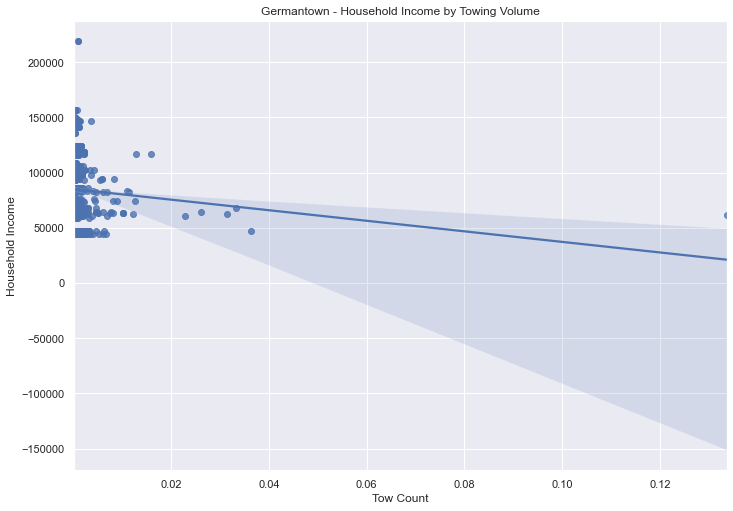

In [86]:
sns.regplot(x = "tow_rate", y = "hh_income", data = gtb)
plt.title("Germantown - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

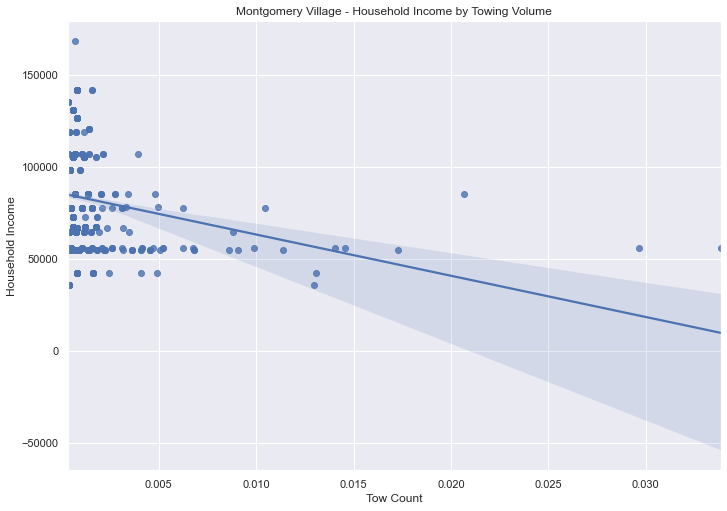

In [87]:
sns.regplot(x = "tow_rate", y = "hh_income", data = mvb)
plt.title("Montgomery Village - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

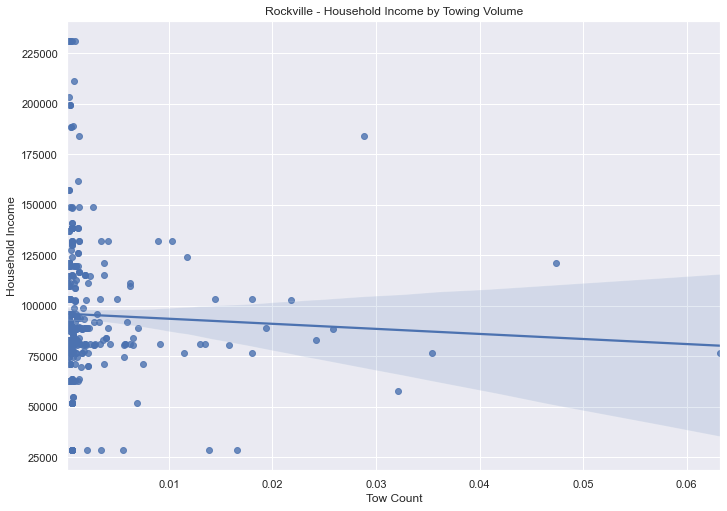

In [88]:
sns.regplot(x = "tow_rate", y = "hh_income", data = rvb)
plt.title("Rockville - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

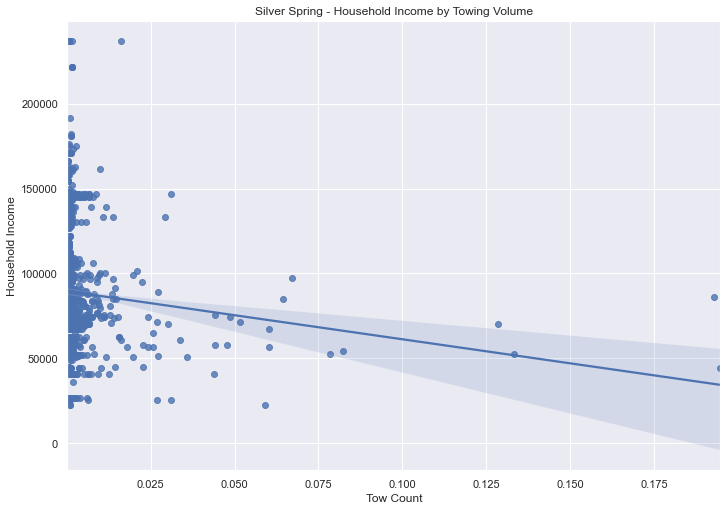

In [89]:
sns.regplot(x = "tow_rate", y = "hh_income", data = ssb)
plt.title("Silver Spring - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

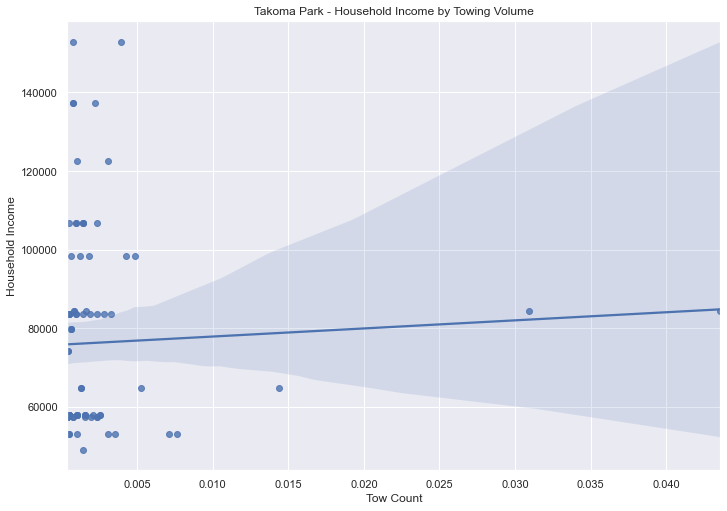

In [90]:
sns.regplot(x = "tow_rate", y = "hh_income", data = tpb)
plt.title("Takoma Park - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

In [91]:
#CREATE MAPS

In [92]:
#Split geo-point to retrieve latitude and longitude
block_split = block_df["geo_location"].str.split(" ", n = 5, expand = True)
print(block_split)


          0            1           2
0     POINT  (-77.175624  39.211873)
1     POINT  (-77.148754  39.211605)
2     POINT  (-77.167752  39.208712)
3     POINT  (-77.141329  39.207148)
4     POINT  (-77.144138  39.147034)
...     ...          ...         ...
5876  POINT  (-77.149295  39.024606)
5877  POINT  (-77.152166  39.026407)
5878  POINT  (-77.152171  39.026405)
5879  POINT  (-77.152785  39.026129)
5880  POINT  (-77.152789  39.026116)

[5881 rows x 3 columns]


In [93]:
#from split create columns: "latitude", "longitude", and 
#"location" for use in maps/gpd
block_df["longitude"] = block_split.iloc[:,1]
block_df["longitude"] = block_df["longitude"].str.replace("(", "")
block_df["latitude"] = block_split.iloc[:,2]
block_df["latitude"] = block_df["latitude"].str.replace(")", "")
block_df["longitude"] = pd.to_numeric(block_df["longitude"])
block_df["latitude"] = pd.to_numeric(block_df["latitude"])
block_df.head()

,block,city,hh_income,pop_total,pop_black,pop_white,geo_location,count_col,tow_rate,longitude,latitude
0,7001012,Gaithersburg,208929,1931,39,1892,POINT (-77.175624 39.211873),1,0.000518,-77.175624,39.211873
1,7001013,Gaithersburg,135208,800,10,790,POINT (-77.148754 39.211605),1,0.001250,-77.148754,39.211605
2,7001013,Gaithersburg,135208,800,10,790,POINT (-77.167752 39.208712),1,0.001250,-77.167752,39.208712
3,7001032,Gaithersburg,218173,1017,193,824,POINT (-77.141329 39.207148),1,0.000983,-77.141329,39.207148
4,7001033,Derwood,172778,3112,345,2767,POINT (-77.144138 39.147034),1,0.000321,-77.144138,39.147034


In [94]:
block_gpd = gpd.GeoDataFrame(block_df, geometry=gpd.points_from_xy(block_df.latitude, block_df.longitude))
block_gpd.info

<bound method DataFrame.info of         block          city  hh_income  pop_total  pop_black  pop_white  \
0     7001012  Gaithersburg     208929       1931         39       1892   
1     7001013  Gaithersburg     135208        800         10        790   
2     7001013  Gaithersburg     135208        800         10        790   
3     7001032  Gaithersburg     218173       1017        193        824   
4     7001033       Derwood     172778       3112        345       2767   
...       ...           ...        ...        ...        ...        ...   
5876  7060123      Bethesda      59205       1032        200        832   
5877  7060123      Bethesda      59205       1032        200        832   
5878  7060123      Bethesda      59205       1032        200        832   
5879  7060123      Bethesda      59205       1032        200        832   
5880  7060123      Bethesda      59205       1032        200        832   

                      geo_location  count_col  tow_rate  longitude 

In [95]:
#New map of tow_rate; areas experiencing greater than upper fence 0.059

m = folium.Map(location=[39.211873, -77.175624],
                     tiles='stamentoner',
                     zoom_start=12,max_bounds=True)

marker_cluster = folium.plugins.MarkerCluster()

#Create a list of coordinate for heatmap input
outlier_df = block_gpd[block_gpd["tow_rate"] >= ufence]
locations = list(zip(outlier_df["latitude"], outlier_df["longitude"]))
from folium.plugins import HeatMap
HeatMap(locations).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
folium.LayerControl().add_to(m)

m

In [96]:
#New map of tow_rate; areas experiencing >=9.19% 

m1 = folium.Map(location=[39.211873, -77.175624],
                     tiles='stamentoner',
                     zoom_start=11,max_bounds=True)

marker_cluster = folium.plugins.MarkerCluster()

#Create a list of coordinate + weight trios for heatmap input
outlier_df = block_gpd[block_gpd["tow_rate"] >= .0919]
locations = list(zip(outlier_df["latitude"], outlier_df["longitude"], outlier_df["tow_rate"]))
from folium.plugins import HeatMap
HeatMap(locations).add_to(folium.FeatureGroup(name='Heat Map').add_to(m1))
folium.LayerControl().add_to(m1)

m1



In [97]:
#MAKE MAP OF OUTLIERS WITH TOOLTIP SHOWING TOWING RATE

In [98]:
#Set new map general area
ch=folium.Map(location=[39.211873, -77.175624])
ch

In [99]:
#fix size of map
from branca.element import Figure
fig=Figure(width=550,height=350)

In [100]:
ch=folium.Map(width=550,height=350,location=[39.211873, -77.175624],zoom_start=11,min_zoom=8,max_zoom=14)
fig.add_child(ch)
ch

In [101]:
#Download Maryland County shapefiles as a geopanda called data0 (for now I have it saved on my computer)
url = "/Users/elizabethclick/Downloads/cb_2018_24_bg_500k/cb_2018_24_bg_500k.shp"
fol_plugin = gpd.read_file(url)
data0 = gpd.GeoDataFrame(fol_plugin)
print(data0.head())
#Refine all counties to Montgomery County only in data1 geopanda of geodata shapes
data1 = data0[data0['COUNTYFP'] == '031'].reset_index()
data1.info()
data1["block"] = data1["TRACTCE"] + data1["BLKGRPCE"]
data1['block'] = data1['block'].astype(int)
#data1.loc["block"] = data1["block"].astype(int)
#data1 = data1.drop_duplicates(subset="GEOID", keep='first', inplace=False, ignore_index=False)
data1 = data1.dropna()
data1.head()
data1.info()

  STATEFP COUNTYFP TRACTCE BLKGRPCE               AFFGEOID         GEOID NAME  \
0      24      047  980000        1  1500000US240479800001  240479800001    1   
1      24      019  970900        2  1500000US240199709002  240199709002    2   
2      24      003  706302        3  1500000US240037063023  240037063023    3   
3      24      027  606606        1  1500000US240276066061  240276066061    1   
4      24      005  491201        1  1500000US240054912011  240054912011    1   

  LSAD      ALAND     AWATER  \
0   BG   36014136  196706380   
1   BG  264765218  196678699   
2   BG     500847     785990   
3   BG     709671          0   
4   BG    1126592          0   

                                            geometry  
0  POLYGON ((-75.37851 38.02457, -75.37755 38.026...  
1  MULTIPOLYGON (((-76.06544 38.12980, -76.06461 ...  
2  POLYGON ((-76.48555 38.97298, -76.48098 38.977...  
3  POLYGON ((-76.82290 39.21282, -76.82172 39.213...  
4  POLYGON ((-76.58843 39.40161, -76.58537 39

In [102]:
ch_df = data1.merge(block_gpd, how='inner', on='block')
ch_df["black_rate"] = ch_df["pop_black"] / ch_df["pop_total"]

In [103]:
ch_subset = ch_df[["block", "hh_income", "tow_rate", "black_rate", "count_col", "geometry_x", "geometry_y", "latitude", "longitude"]].copy()

In [104]:
ch_subset.info()
markers = list(ch_subset[['latitude', 'longitude']].itertuples(index=False, name=None))
ch_subset["marks"] = markers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5881 entries, 0 to 5880
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   block       5881 non-null   int64   
 1   hh_income   5881 non-null   int64   
 2   tow_rate    5881 non-null   float64 
 3   black_rate  5881 non-null   float64 
 4   count_col   5881 non-null   int64   
 5   geometry_x  5881 non-null   geometry
 6   geometry_y  5881 non-null   geometry
 7   latitude    5881 non-null   float64 
 8   longitude   5881 non-null   float64 
dtypes: float64(4), geometry(2), int64(3)
memory usage: 459.5 KB


In [105]:
# Creating Basemap
fig4=Figure(height=350,width=550)
ch1=folium.Map(location=[39.15010, -77.06276],tiles='cartodbpositron',zoom_start=11)
fig4.add_child(ch1)

# Adding Custom Markers
folium.Marker(location=[39.04311, -77.05381], popup='Custom Marker 1',tooltip='<strong>Click here to see Popup</strong>',icon=folium.Icon(color='red',icon='none')).add_to(ch1)

ch1

In [106]:
outliers_df = ch_subset[ch_subset["tow_rate"] >= .0919]

map_outliers = folium.Map(location=[39.15010, -77.06276], zoom_start=11)

for i,r in outliers_df.iterrows():
    folium.Marker(location=r['marks'],
                  popup = r['black_rate'],
                  tooltip='Click for more information!').add_to(map_outliers)
map_outliers

In [107]:
#Using IQR fence calculation ufence = 0.059 from earlier boxplots
aboveavg_df = ch_subset[ch_subset["tow_rate"] >= ufence]

map_aboveavg = folium.Map(location=[39.15010, -77.06276], zoom_start=11)

for i,r in aboveavg_df.iterrows():
    folium.Marker(location=r['marks'],
                  popup = r['hh_income'],
                  tooltip='Click for more information!').add_to(map_aboveavg)
map_aboveavg